In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pickle
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Завантажуємо датасет
df = pd.read_csv('book_details.csv', encoding='latin-1')

print("=== ЗАВАНТАЖЕННЯ ДАТАСЕТУ ===")
print(f"Загальна кількість книг: {len(df)}")
print(f"Колонки: {df.columns.tolist()}")
print(f"Розмір: {df.shape}")

df.head()

=== ЗАВАНТАЖЕННЯ ДАТАСЕТУ ===
Загальна кількість книг: 13324
Колонки: ['title', 'author', 'rating', 'no_of_ratings', 'no_of_reviews', 'description', 'genres']
Розмір: (13324, 7)


,title,author,rating,no_of_ratings,no_of_reviews,description,genres
0,Divergent,Veronica Roth,4.15,3765886,"117,791","In Beatrice Prior's dystopian Chicago world, s...","Young Adult, Dystopia, Fantasy, Fiction, Scien..."
1,Catching Fire,Suzanne Collins,4.31,3305054,"113,480",Sparks are igniting.Flames are spreading.And t...,"Young Adult, Dystopia, Fiction, Fantasy, Scien..."
2,The Fault in Our Stars,John Green,4.15,4851513,"174,662",Despite the tumor-shrinking medical miracle th...,"Young Adult, Romance, Fiction, Contemporary, R..."
3,To Kill a Mockingbird,Harper Lee,4.27,5784553,"112,055",The unforgettable novel of a childhood in a sl...,"Classics, Fiction, Historical Fiction, School,..."
4,The Lightning Thief,Rick Riordan,4.30,2752945,"87,446",Alternate cover for this ISBN can be found her...,"Fantasy, Young Adult, Mythology, Fiction, Midd..."


=== АНАЛІЗ ДАНИХ ДО ОБРОБКИ ===
Розмір датасету: (13324, 7)

Порожні значення по колонкам:
title              0
author             0
rating             0
no_of_ratings      0
no_of_reviews      0
description       51
genres           997
dtype: int64

Статистика по основних полях:
Унікальних авторів: 7979
Унікальних жанрів: 10935
Середня довжина опису: 980 символів


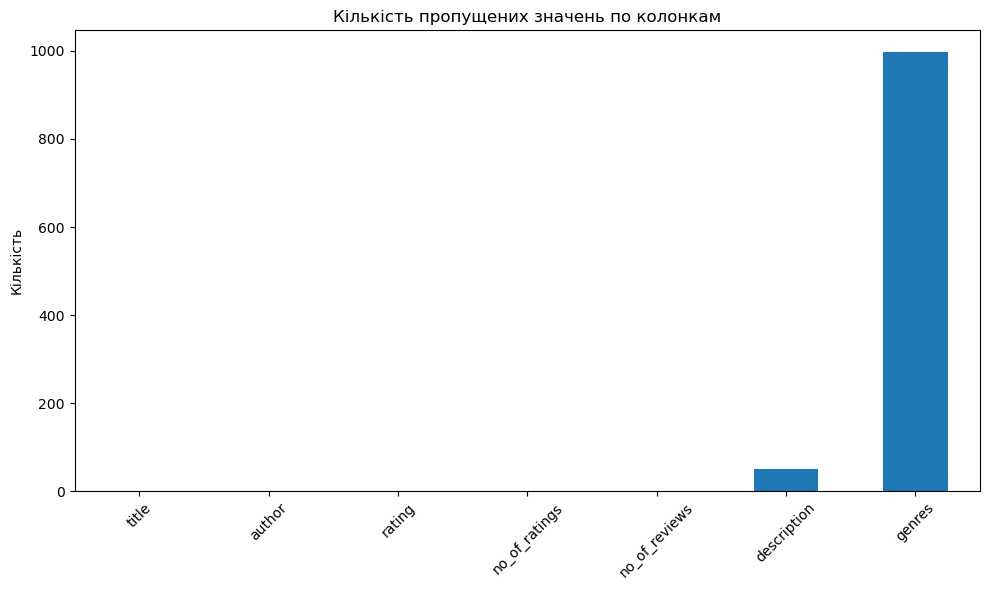

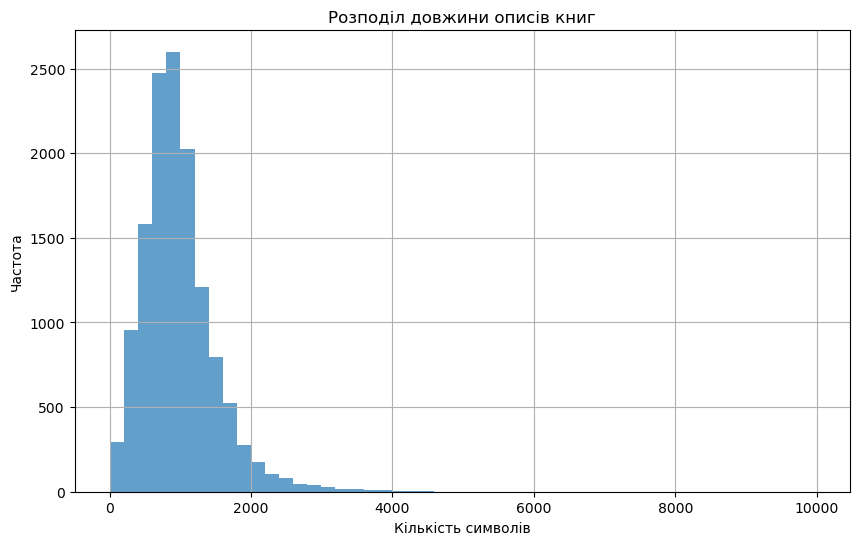

In [3]:
print("=== АНАЛІЗ ДАНИХ ДО ОБРОБКИ ===")
print(f"Розмір датасету: {df.shape}")
print("\nПорожні значення по колонкам:")
missing_data = df.isnull().sum()
print(missing_data)

print("\nСтатистика по основних полях:")
print(f"Унікальних авторів: {df['author'].nunique()}")
print(f"Унікальних жанрів: {df['genres'].nunique()}")
print(f"Середня довжина опису: {df['description'].str.len().mean():.0f} символів")

# Візуалізація пропущених даних
plt.figure(figsize=(10, 6))
missing_data.plot(kind='bar')
plt.title('Кількість пропущених значень по колонкам')
plt.ylabel('Кількість')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Розподіл довжини описів
plt.figure(figsize=(10, 6))
df['description'].str.len().hist(bins=50, alpha=0.7)
plt.title('Розподіл довжини описів книг')
plt.xlabel('Кількість символів')
plt.ylabel('Частота')
plt.show()

In [4]:
print("=== ОЧИСТКА ДАНИХ ===")

# Залишаємо потрібні колонки
df_clean = df[['title', 'author', 'genres', 'description']].copy()

print(f"Початкова кількість записів: {len(df_clean)}")

# Заповнюємо пропущені значення
df_clean['author'] = df_clean['author'].fillna('Unknown Author').astype(str)
df_clean['genres'] = df_clean['genres'].fillna('Unknown Genre').astype(str)
df_clean['description'] = df_clean['description'].fillna('No Description').astype(str)

# Очищуємо проблемні символи
df_clean['author'] = df_clean['author'].str.replace('�', '', regex=False)
df_clean['genres'] = df_clean['genres'].str.replace('�', '', regex=False)
df_clean['description'] = df_clean['description'].str.replace('�', '', regex=False)

# Формуємо комбінований текст
df_clean['combined_text'] = (
    df_clean['author'] + ' ' + 
    df_clean['genres'] + ' ' + 
    df_clean['description']
).str.strip()

# Видаляємо записи з порожнім текстом
initial_count = len(df_clean)
df_clean = df_clean[df_clean['combined_text'].str.strip() != ''].copy()
final_count = len(df_clean)

print(f"Видалено записів з порожнім текстом: {initial_count - final_count}")
print(f"Залишилось записів: {final_count}")

# Статистика після очистки
print(f"\nСтатистика після очистки:")
print(f"Середня довжина комбінованого тексту: {df_clean['combined_text'].str.len().mean():.0f} символів")
print(f"Максимальна довжина: {df_clean['combined_text'].str.len().max()} символів")
print(f"Мінімальна довжина: {df_clean['combined_text'].str.len().min()} символів")

=== ОЧИСТКА ДАНИХ ===
Початкова кількість записів: 13324
Видалено записів з порожнім текстом: 0
Залишилось записів: 13324

Статистика після очистки:
Середня довжина комбінованого тексту: 1060 символів
Максимальна довжина: 10055 символів
Мінімальна довжина: 35 символів


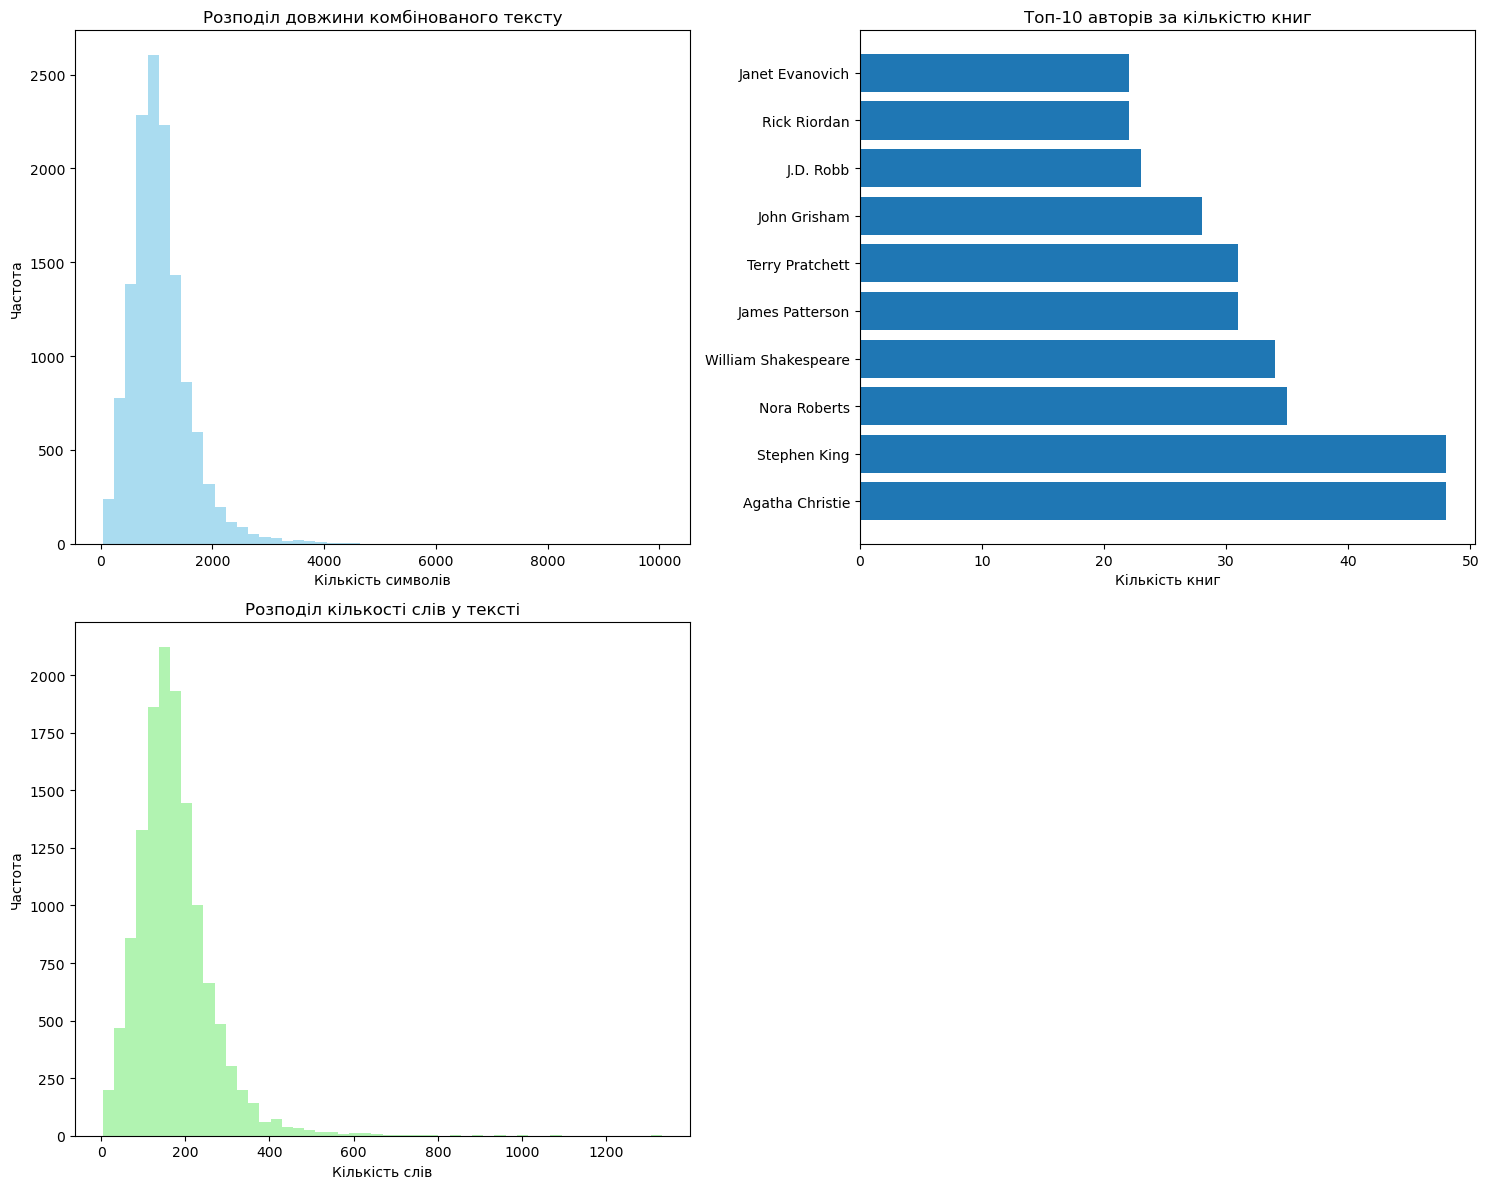

In [5]:
# Візуалізація даних після очистки
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Розподіл довжини комбінованого тексту
axes[0,0].hist(df_clean['combined_text'].str.len(), bins=50, alpha=0.7, color='skyblue')
axes[0,0].set_title('Розподіл довжини комбінованого тексту')
axes[0,0].set_xlabel('Кількість символів')
axes[0,0].set_ylabel('Частота')

# Топ-10 авторів
top_authors = df_clean['author'].value_counts().head(10)
axes[0,1].barh(range(len(top_authors)), top_authors.values)
axes[0,1].set_yticks(range(len(top_authors)))
axes[0,1].set_yticklabels(top_authors.index)
axes[0,1].set_title('Топ-10 авторів за кількістю книг')
axes[0,1].set_xlabel('Кількість книг')

# Розподіл слів у комбінованому тексті
word_counts = df_clean['combined_text'].str.split().str.len()
axes[1,0].hist(word_counts, bins=50, alpha=0.7, color='lightgreen')
axes[1,0].set_title('Розподіл кількості слів у тексті')
axes[1,0].set_xlabel('Кількість слів')
axes[1,0].set_ylabel('Частота')


axes[1,1].axis('off')

plt.tight_layout()
plt.show()

In [6]:
print("=== НАВЧАННЯ TF-IDF ВЕКТОРИЗАТОРА ===")

# Налаштування векторизатора
vectorizer = TfidfVectorizer(
    max_features=5000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1, 2),
    stop_words='english',
    lowercase=True,
    strip_accents='unicode'
)

# Навчання на комбінованому тексті
corpus = df_clean['combined_text'].tolist()
tfidf_matrix = vectorizer.fit_transform(corpus)

print(f"Кількість документів: {len(corpus)}")
print(f"Форма TF-IDF матриці: {tfidf_matrix.shape}")
print(f"Кількість унікальних слів: {len(vectorizer.get_feature_names_out())}")

# Статистика матриці
density = (tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1])) * 100
print(f"Щільність матриці: {density:.3f}%")
print(f"Ненульових елементів: {tfidf_matrix.nnz:,}")

# Найчастіші слова у корпусі
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1
word_scores = list(zip(feature_names, tfidf_scores))
word_scores.sort(key=lambda x: x[1], reverse=True)

print(f"\nТоп-15 слів за TF-IDF:")
for word, score in word_scores[:15]:
    print(f"{word}: {score:.3f}")

=== НАВЧАННЯ TF-IDF ВЕКТОРИЗАТОРА ===
Кількість документів: 13324
Форма TF-IDF матриці: (13324, 5000)
Кількість унікальних слів: 5000
Щільність матриці: 1.289%
Ненульових елементів: 858,530

Топ-15 слів за TF-IDF:
fiction: 454.260
romance: 362.159
life: 335.746
fantasy: 300.238
new: 285.080
adult: 268.112
love: 263.752
world: 262.681
young: 250.928
historical: 243.005
contemporary: 240.567
mystery: 239.271
book: 215.306
story: 204.636
time: 196.878


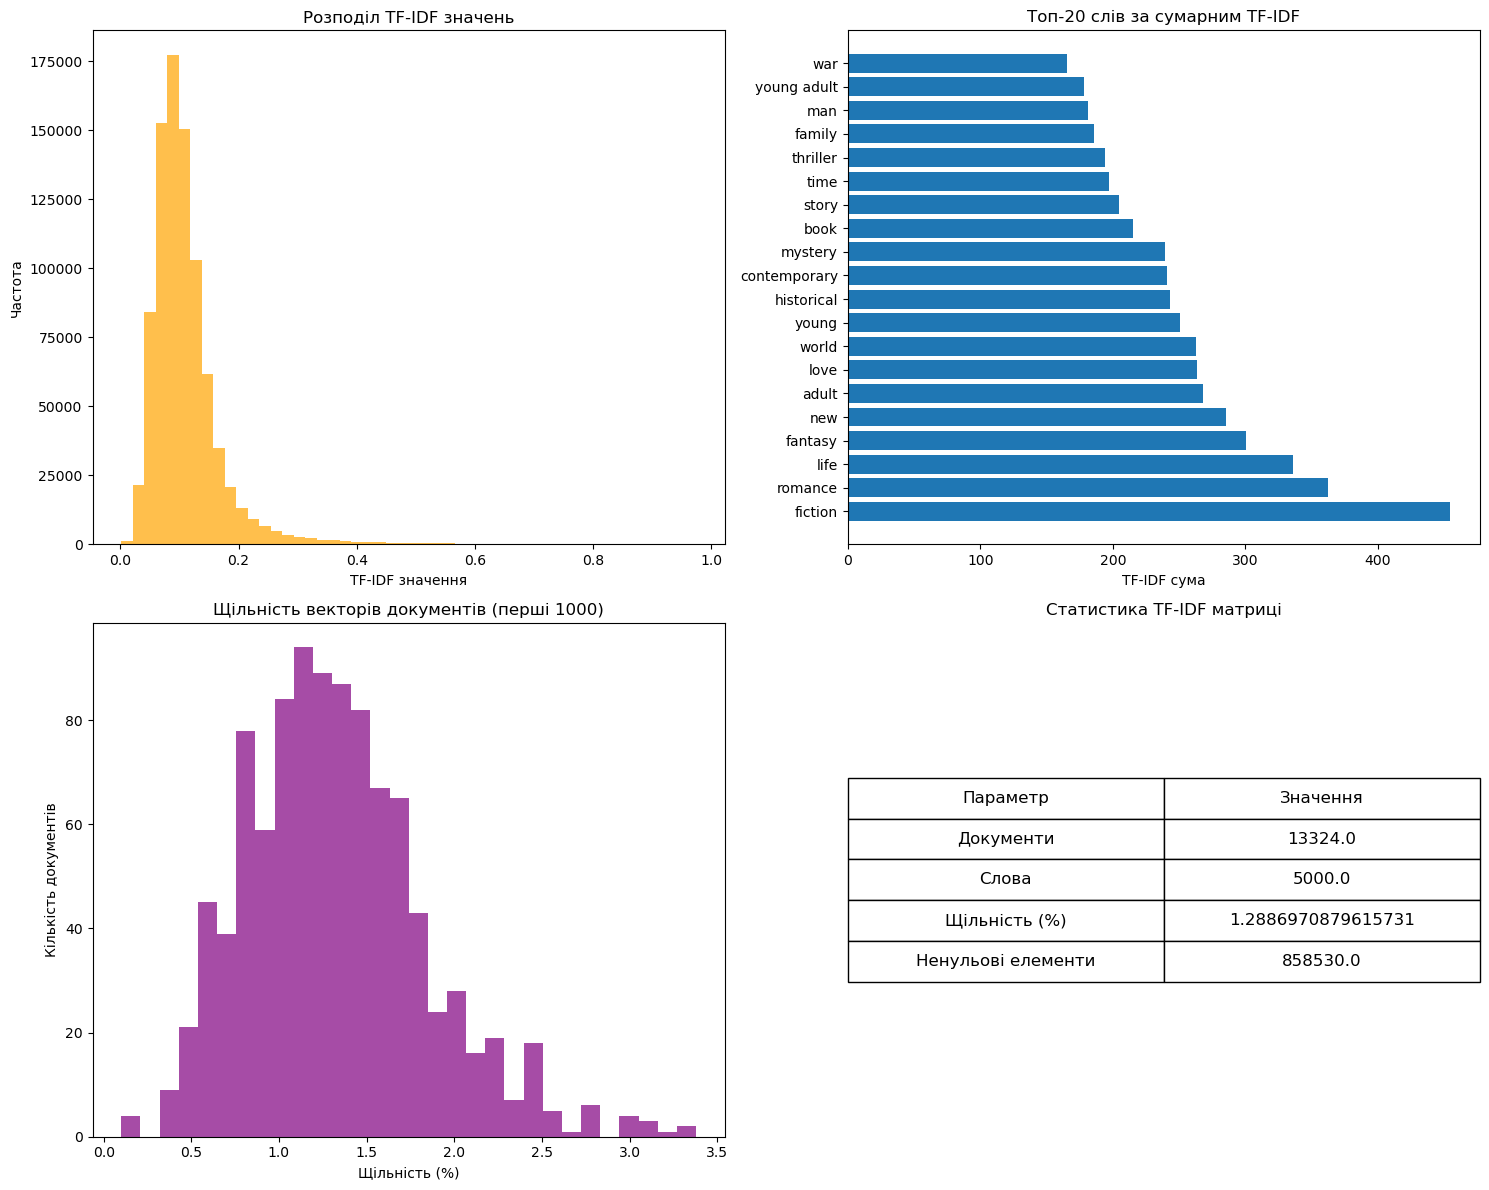

In [7]:
# Візуалізація TF-IDF результатів
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Розподіл TF-IDF значень
tfidf_values = tfidf_matrix.data
axes[0,0].hist(tfidf_values, bins=50, alpha=0.7, color='orange')
axes[0,0].set_title('Розподіл TF-IDF значень')
axes[0,0].set_xlabel('TF-IDF значення')
axes[0,0].set_ylabel('Частота')

# Топ-20 слів за TF-IDF
top_words = word_scores[:20]
words, scores = zip(*top_words)
axes[0,1].barh(range(len(top_words)), scores)
axes[0,1].set_yticks(range(len(top_words)))
axes[0,1].set_yticklabels(words)
axes[0,1].set_title('Топ-20 слів за сумарним TF-IDF')
axes[0,1].set_xlabel('TF-IDF сума')

# Щільність матриці по документах
doc_densities = np.array([(tfidf_matrix[i].nnz / tfidf_matrix.shape[1]) * 100 
                         for i in range(min(1000, tfidf_matrix.shape[0]))])
axes[1,0].hist(doc_densities, bins=30, alpha=0.7, color='purple')
axes[1,0].set_title('Щільність векторів документів (перші 1000)')
axes[1,0].set_xlabel('Щільність (%)')
axes[1,0].set_ylabel('Кількість документів')

# Статистика матриці
matrix_stats = pd.DataFrame({
    'Параметр': ['Документи', 'Слова', 'Щільність (%)', 'Ненульові елементи'],
    'Значення': [tfidf_matrix.shape[0], tfidf_matrix.shape[1], 
                density, tfidf_matrix.nnz]
})

axes[1,1].axis('off')
table = axes[1,1].table(cellText=matrix_stats.values,
                       colLabels=matrix_stats.columns,
                       cellLoc='center',
                       loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 2)
axes[1,1].set_title('Статистика TF-IDF матриці')

plt.tight_layout()
plt.show()

In [8]:
def get_content_recommendations(book_indices, top_k=8):
    """
    Отримати content-based рекомендації на основі косинусної подібності
    """
    if not book_indices or len(book_indices) == 0:
        return [], []
    
    # Отримуємо вектори обраних книг
    user_vectors = tfidf_matrix[book_indices]
    
    # Створюємо профіль користувача (середній вектор)
    if len(book_indices) == 1:
        user_profile = user_vectors.toarray()  # Конвертуємо sparse matrix в dense array
    else:
        user_profile = user_vectors.mean(axis=0).A1.reshape(1, -1)  # Конвертуємо в 2D numpy array
    
    # Обчислюємо косинусну подібність з усіма книгами
    similarities = cosine_similarity(user_profile, tfidf_matrix).ravel()
    
    # Виключаємо вже переглянуті книги
    for idx in book_indices:
        similarities[idx] = -1
    
    # Знаходимо топ рекомендації
    top_indices = similarities.argsort()[-top_k:][::-1]
    top_similarities = similarities[top_indices]
    
    return top_indices, top_similarities

def display_recommendations(book_indices, recommendations_indices, similarities, title="Рекомендації"):
    """
    Відображення рекомендацій
    """
    print(f"\n=== {title.upper()} ===")
    print("Базові книги:")
    for i, idx in enumerate(book_indices):
        book = df_clean.iloc[idx]
        print(f"{i+1}. {book['title']} - {book['author']}")
        print(f"   Жанри: {book['genres']}")
    
    print(f"\nРекомендовані книги:")
    for i, (idx, sim) in enumerate(zip(recommendations_indices, similarities)):
        book = df_clean.iloc[idx]
        print(f"{i+1}. {book['title']} - {book['author']} (подібність: {sim:.3f})")
        print(f"   Жанри: {book['genres']}")

In [27]:
print("=== ТЕСТУВАННЯ РЕКОМЕНДАЦІЙ ===")

# Тест 1: Рекомендації на основі однієї книги
single_book = [0]
rec_indices_1, similarities_1 = get_content_recommendations(single_book, top_k=10)
display_recommendations(single_book, rec_indices_1, similarities_1, 
                       "Рекомендації на основі однієї книги")

=== ТЕСТУВАННЯ РЕКОМЕНДАЦІЙ ===

=== РЕКОМЕНДАЦІЇ НА ОСНОВІ ОДНІЄЇ КНИГИ ===
Базові книги:
1. Divergent - Veronica Roth
   Жанри: Young Adult, Dystopia, Fantasy, Fiction, Science Fiction, Romance, Adventure

Рекомендовані книги:
1. Insurgent - Veronica Roth (подібність: 0.216)
   Жанри: Young Adult, Dystopia, Fiction, Fantasy, Science Fiction, Romance, Adventure
2. The Circle: Taken - Sage Sask (подібність: 0.214)
   Жанри: Young Adult, Dystopia, Science Fiction, Fantasy, Fiction
3. Birthmarked - Caragh M. O'Brien (подібність: 0.203)
   Жанри: Young Adult, Dystopia, Fantasy, Science Fiction, Fiction, Romance, Post Apocalyptic
4. The Remedy Files: Illusion - Lauren Eckhardt (подібність: 0.185)
   Жанри: Young Adult, Dystopia, Romance, Science Fiction, Mystery
5. Crossed - Ally Condie (подібність: 0.181)
   Жанри: Young Adult, Dystopia, Romance, Science Fiction, Fiction, Fantasy, Teen
6. These Ruthless Deeds - Tarun Shanker (подібність: 0.161)
   Жанри: Fantasy, Young Adult, Historical F

In [9]:
# Тест 2: Рекомендації на основі двох книг
two_books = [0, 5]
rec_indices_2, similarities_2 = get_content_recommendations(two_books, top_k=10)
display_recommendations(two_books, rec_indices_2, similarities_2, 
                       "Рекомендації на основі двох книг")


=== РЕКОМЕНДАЦІЇ НА ОСНОВІ ДВОХ КНИГ ===
Базові книги:
1. Divergent - Veronica Roth
   Жанри: Young Adult, Dystopia, Fantasy, Fiction, Science Fiction, Romance, Adventure
2. Harry Potter and the Prisoner of Azkaban - J.K. Rowling
   Жанри: Fantasy, Fiction, Young Adult, Magic, Childrens, Middle Grade, Audiobook

Рекомендовані книги:
1. Harry Potter and the Order of the Phoenix - J.K. Rowling (подібність: 0.414)
   Жанри: Fantasy, Young Adult, Fiction, Magic, Childrens, Audiobook, Adventure
2. Harry Potter and the Chamber of Secrets - J.K. Rowling (подібність: 0.404)
   Жанри: Fantasy, Fiction, Young Adult, Magic, Childrens, Middle Grade, Audiobook
3. Harry Potter and the Goblet of Fire - J.K. Rowling (подібність: 0.372)
   Жанри: Fantasy, Young Adult, Fiction, Magic, Childrens, Middle Grade, Audiobook
4. Harry Potter and the Half-Blood Prince - J.K. Rowling (подібність: 0.310)
   Жанри: Fantasy, Young Adult, Fiction, Magic, Childrens, Adventure, Audiobook
5. Harry Potter and the Curse

In [10]:
# Тест 3: Рекомендації на основі трьох книг різних жанрів
three_books = [0, 10, 20]
rec_indices_3, similarities_3 = get_content_recommendations(three_books, top_k=10)
display_recommendations(three_books, rec_indices_3, similarities_3, 
                       "Рекомендації на основі трьох різних книг")


=== РЕКОМЕНДАЦІЇ НА ОСНОВІ ТРЬОХ РІЗНИХ КНИГ ===
Базові книги:
1. Divergent - Veronica Roth
   Жанри: Young Adult, Dystopia, Fantasy, Fiction, Science Fiction, Romance, Adventure
2. Pride and Prejudice - Jane Austen
   Жанри: Classics, Fiction, Romance, Historical Fiction, Literature, Historical, Audiobook
3. If I Stay - Gayle Forman
   Жанри: Young Adult, Romance, Contemporary, Fiction, Realistic Fiction, Teen, Music

Рекомендовані книги:
1. The Watsons - Jane Austen (подібність: 0.328)
   Жанри: Classics, Fiction, Romance, Historical Fiction, Audiobook, Classic Literature, Literature
2. The Complete Novels - Jane Austen (подібність: 0.321)
   Жанри: Classics, Fiction, Romance, Historical Fiction, Literature, Historical, Classic Literature
3. Emma - Jane Austen (подібність: 0.321)
   Жанри: Classics, Fiction, Romance, Historical Fiction, Literature, Historical, Audiobook
4. Pride and Prejudice, Mansfield Park, Persuasion - Jane Austen (подібність: 0.293)
   Жанри: Classics, Fiction, 

In [15]:
# Створюємо словник з усіма компонентами моделі
content_model = {
    'vectorizer': vectorizer,
    'book_data': df_clean[['title', 'author', 'genres', 'description']].reset_index(drop=True),
    'tfidf_matrix': tfidf_matrix,
    'model_info': {
        'total_books': len(df_clean),
        'vocabulary_size': len(vectorizer.get_feature_names_out()),
        'matrix_density': density,
        'features': tfidf_matrix.shape[1]
    }
}

# Зберігаємо 
vectorizer_path = '/home/stanislav/diplom/recommendations/tfidf_vectorizer.pkl'
with open(vectorizer_path, 'wb') as f:
    pickle.dump(vectorizer, f)